<a href="https://colab.research.google.com/github/chaitanya-kh/regression_models/blob/master/Boston_housing_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression example with Boston housing dataset

## Description

Following is covered in this notebook


*   Downloading and checking the data
*   Plotting correlations and heat maps
*   Extracting right features and Feature scaling
*   Building and evaluating ML models for prediction
     *    Linear regression
     *    Decision trees
     *    Random forests
     *    Random forests with grid search and hyper-parameter tuning
     *    Deep learning with Neural networks using keras
     *    Deep learning with neural networks and batch normalization using tf
*   Comparing results of all the models
     



##    Downloading and checking the data





In [1]:
# Import all the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

%matplotlib inline

Using TensorFlow backend.


In [2]:
print(tf.__version__)

1.14.0-rc1


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(test_split=0.2, seed=4)

57344/57026 [==============================] - 0s 0us/step


In [4]:
print ('x_train.shape: ', x_train.shape)
print ('y_train.shape: ', y_train.shape)
print ('x_test.shape: ', x_test.shape)
print ('y_test.shape: ', y_test.shape)

x_train.shape:  (404, 13)
y_train.shape:  (404,)
x_test.shape:  (102, 13)
y_test.shape:  (102,)


Above prints show that there are 404 entries in training set with 13 features

In [0]:
#Lets take all the training data into pandas dataframe for checking the data and visualizations
training_df = pd.DataFrame(data=np.concatenate((x_train, y_train.reshape(y_train.shape[0],1)), axis=1),
                          columns=(['inp'+str(i) for i in range(1,x_train.shape[1]+1)] + ['op']),
                          index=[i for i in range(0,y_train.shape[0])])

#TODO: add test data also to df and make sure entire dataset is fine

In [6]:
training_df.head()

,inp1,inp2,inp3,inp4,inp5,inp6,inp7,inp8,inp9,inp10,inp11,inp12,inp13,op
0,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
1,0.04297,52.5,5.32,0.0,0.405,6.565,22.9,7.3172,6.0,293.0,16.6,371.72,9.51,24.8
2,0.13554,12.5,6.07,0.0,0.409,5.594,36.8,6.4980,4.0,345.0,18.9,396.90,13.09,17.4
3,0.37578,0.0,10.59,1.0,0.489,5.404,88.6,3.6650,4.0,277.0,18.6,395.24,23.98,19.3
4,0.38214,0.0,6.20,0.0,0.504,8.040,86.5,3.2157,8.0,307.0,17.4,387.38,3.13,37.6


In [7]:
training_df.describe()

,inp1,inp2,inp3,inp4,inp5,inp6,inp7,inp8,inp9,inp10,inp11,inp12,inp13,op
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.722937,10.900990,11.206361,0.081683,0.555881,6.283198,68.751980,3.766014,9.571782,408.797030,18.507673,357.861114,12.728168,22.515842
std,9.228087,22.889612,6.849108,0.274221,0.114524,0.728594,28.076567,2.072454,8.668834,169.021394,2.153805,89.538255,7.013925,9.323734
min,0.009060,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.920000,5.000000
25%,0.085947,0.000000,5.190000,0.000000,0.456750,5.877750,44.225000,2.106075,4.000000,279.000000,17.400000,375.910000,7.177500,16.700000
50%,0.265035,0.000000,9.690000,0.000000,0.538000,6.198500,77.750000,3.167500,5.000000,330.000000,19.100000,391.385000,11.855000,21.000000
75%,3.594927,12.500000,18.100000,0.000000,0.624000,6.608500,94.300000,5.104475,24.000000,666.000000,20.200000,396.080000,17.112500,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


count in above table shows that no data is missing

## Plotting correlations and heat maps

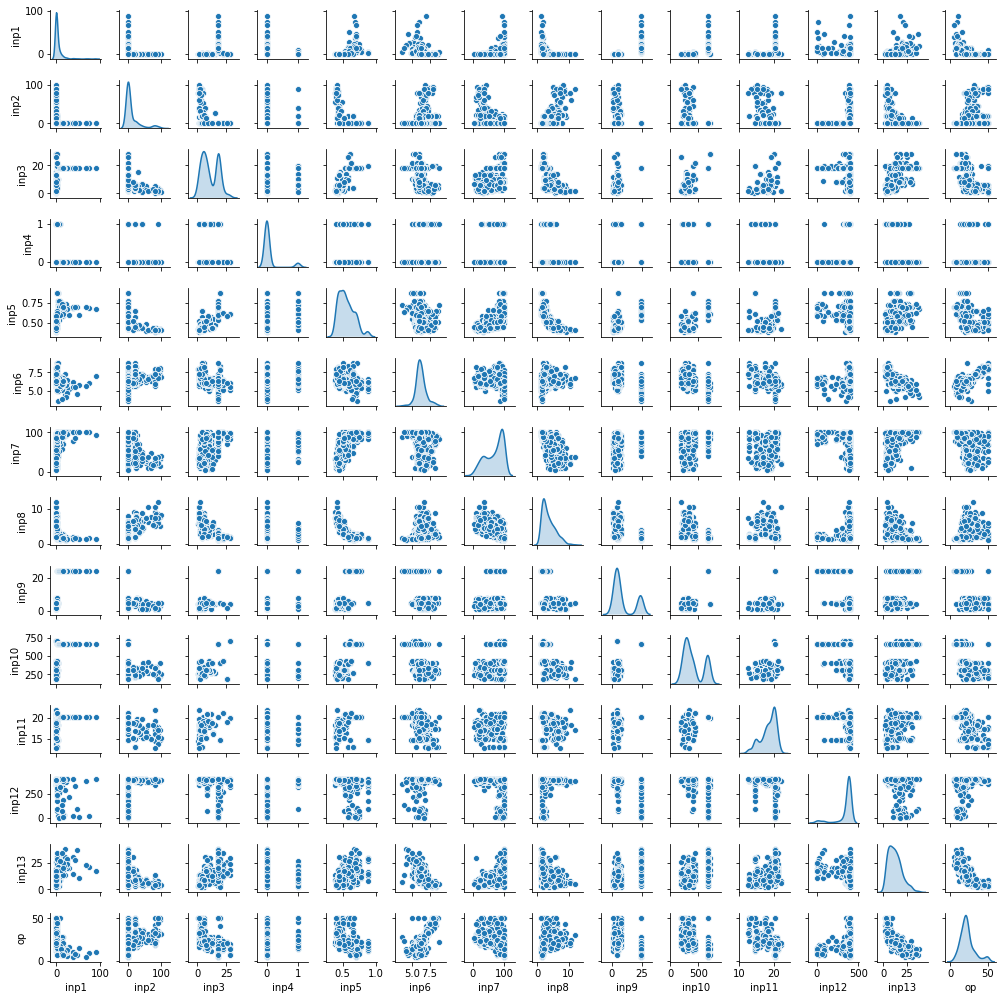

In [8]:
#Check the distribution of all features and how all the features varies wrt output
sns.pairplot(training_df, diag_kind='kde', height=1)

From above plot, can infer the following
*  looks like inp4 is categorical and takes 2 values 0/1
*  Distribution of op looks fine without outliers

In [9]:
training_df.corr()

,inp1,inp2,inp3,inp4,inp5,inp6,inp7,inp8,inp9,inp10,inp11,inp12,inp13,op
inp1,1.000000,-0.188054,0.387153,-0.063944,0.401547,-0.197250,0.338431,-0.365911,0.605540,0.559317,0.273737,-0.375252,0.425888,-0.383269
inp2,-0.188054,1.000000,-0.525206,-0.035474,-0.508243,0.337630,-0.558249,0.651650,-0.300843,-0.332301,-0.391759,0.166641,-0.433725,0.394583
inp3,0.387153,-0.525206,1.000000,0.067459,0.755561,-0.403478,0.625489,-0.703593,0.586637,0.738347,0.397154,-0.338112,0.604158,-0.507299
inp4,-0.063944,-0.035474,0.067459,1.000000,0.101755,0.086260,0.086531,-0.099171,-0.022828,-0.050555,-0.151892,0.046797,-0.050908,0.169722
inp5,0.401547,-0.508243,0.755561,0.101755,1.000000,-0.307553,0.716373,-0.766423,0.595102,0.661696,0.165068,-0.364823,0.581813,-0.432871
inp6,-0.197250,0.337630,-0.403478,0.086260,-0.307553,1.000000,-0.242388,0.212361,-0.212140,-0.303952,-0.377460,0.119888,-0.607688,0.705423
inp7,0.338431,-0.558249,0.625489,0.086531,0.716373,-0.242388,1.000000,-0.719272,0.445404,0.510078,0.244074,-0.265288,0.608703,-0.393735
inp8,-0.365911,0.651650,-0.703593,-0.099171,-0.766423,0.212361,-0.719272,1.000000,-0.485741,-0.541594,-0.216260,0.279271,-0.494995,0.265011
inp9,0.605540,-0.300843,0.586637,-0.022828,0.595102,-0.212140,0.445404,-0.485741,1.000000,0.903848,0.448132,-0.428431,0.467429,-0.389879
inp10,0.559317,-0.332301,0.738347,-0.050555,0.661696,-0.303952,0.510078,-0.541594,0.903848,1.000000,0.463888,-0.424592,0.538293,-0.491586


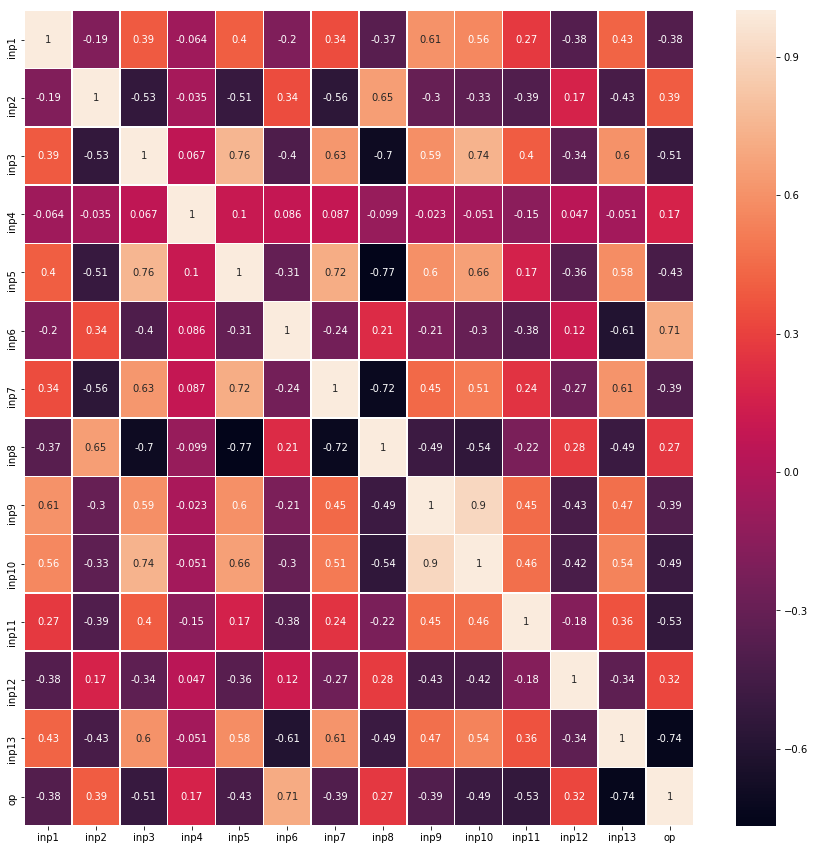

In [10]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
sns.heatmap(training_df.corr(), annot=True, linewidths=0.5)

inp8 and inp12 doesn't have good correlation with op so better to drop them for linear regression

## Extracting right features and Feature scaling

In [0]:
#Feature scaling is necessary for most of the ML models

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train_s = sc_x.fit_transform(x_train)
y_train_s = sc_y.fit_transform(y_train.reshape(-1,1))
x_test_s = sc_x.transform(x_test)
y_test_s = sc_y.transform(y_test.reshape(-1,1))

#Lets remove inp8 and inp12 for linear regression which has low correlation with op
x_train_s_lin = x_train_s[:, [0,1,2,4,5,6,8,9,10,12]]
x_test_s_lin = x_test_s[:, [0,1,2,4,5,6,8,9,10,12]]

## Building and evaluating ML models for prediction

### Helper functions

In [0]:
#Function to plot 
def plot_curves(yp, yt):
  plt.figure(figsize=(15,5))
  plt.plot(yp, color='red', marker='o')
  plt.plot(yt, color='blue', marker='x')
  plt.title('Test set: pred vs true')
  plt.ylabel('op')
  plt.xlabel('n')
  plt.legend(['predicted', 'true'], loc='upper right')
  

#Function to caclulate regressor errors
def calc_regressor_errors(yp, yt):
  mse = np.sum((yp - yt)*(yp - yt))/yp.shape[0]
  mae = np.sum(np.abs((yp - yt)))/yp.shape[0]
  print ("MSE is: ", mse, "\nMAE is: ", mae)
      
  error_percent = (yp-yt)/yt*100
  print ("mean error percent: ", np.mean(np.abs(error_percent)))
  print ("SD of error percent: ", np.std(error_percent))
  print ("max error percent: ", np.max(error_percent))
  print ("min error percent: ", np.min(error_percent))
  plt.title('error percentage distribution')
  plt.ylabel('error percent')
  sns.kdeplot(error_percent)
  
  acc_5p = len(np.where((error_percent>=-5) & (error_percent<=5))[0])/len(yp)
  acc_10p = len(np.where((error_percent>=-10) & (error_percent<=10))[0])/len(yp)
  acc_15p = len(np.where((error_percent>=-15) & (error_percent<=15))[0])/len(yp)
  acc_20p = len(np.where((error_percent>=-20) & (error_percent<=20))[0])/len(yp)
  
  print('+/- 5% accuracy: ',acc_5p*100,'%')
  print('+/- 10% accuracy: ',acc_10p*100,'%')
  print('+/- 15% accuracy: ',acc_15p*100,'%')
  print('+/- 20% accuracy: ',acc_20p*100,'%')
  
  plot_curves(yp, yt)
  
  
#Function to 
def predict_and_plot(x_val, y_val, model, inv):
  y_pred = model.predict(x_val)
  if inv:
    y_pred = sc_y.inverse_transform(y_pred)
  y_pred = y_pred.reshape(-1,)

  calc_regressor_errors(y_pred, y_val)

  

### Linear regression model

In [13]:
#Fitting simple linear regression to training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train_s, y_train_s)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MSE is:  21.14276412449531 
MAE is:  3.2327745826411713
mean error percent:  16.30804290363545
SD of error percent:  24.540577980763793
max error percent:  141.3829845537183
min error percent:  -164.37980666405255
+/- 5% accuracy:  25.0 %
+/- 10% accuracy:  44.554455445544555 %
+/- 15% accuracy:  61.386138613861384 %
+/- 20% accuracy:  73.01980198019803 %


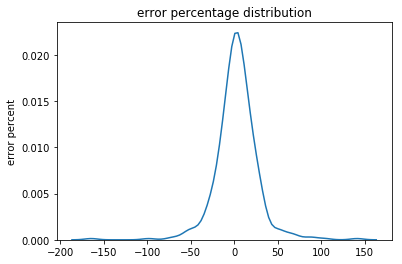

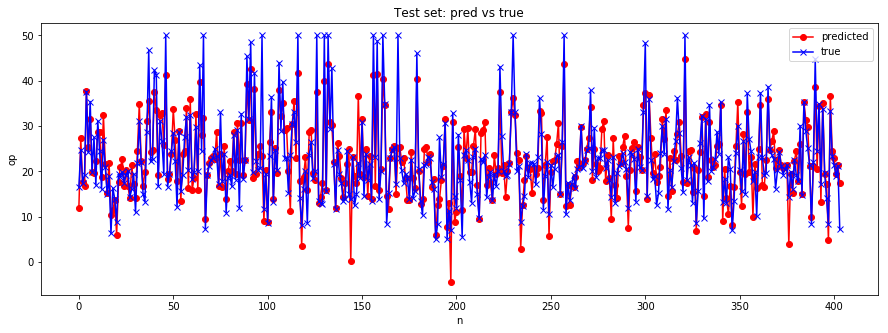

In [14]:
#Predicting and plotting the training set result
predict_and_plot(x_train_s, y_train, regressor, True)

MSE is:  25.32905694860009 
MAE is:  3.4337090424659684
mean error percent:  16.359388959986216
SD of error percent:  22.950392983649056
max error percent:  77.48840231622563
min error percent:  -91.30365560587919
+/- 5% accuracy:  26.47058823529412 %
+/- 10% accuracy:  43.13725490196079 %
+/- 15% accuracy:  57.84313725490197 %
+/- 20% accuracy:  74.50980392156863 %


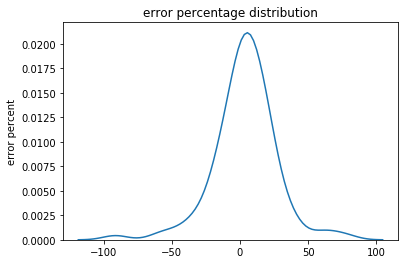

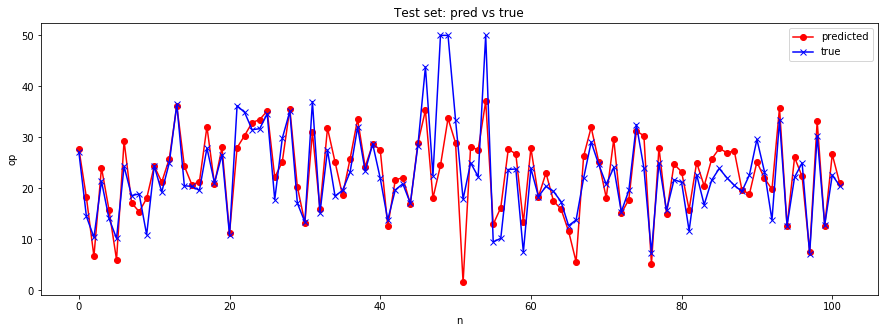

In [15]:
#Predicting and plotting the test set result
predict_and_plot(x_test_s, y_test, regressor, True)

### Decision tree regression model

In [16]:
#Fitting simple Decision tree regression to training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=9, max_leaf_nodes=140, random_state=10)
regressor.fit(x_train_s, y_train_s)


DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=140, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=10, splitter='best')

MSE is:  1.07582474038249 
MAE is:  0.6320050054051947
mean error percent:  3.4848899539242315
SD of error percent:  6.1784154053521885
max error percent:  47.3611111111111
min error percent:  -15.120000000000006
+/- 5% accuracy:  76.23762376237624 %
+/- 10% accuracy:  92.32673267326733 %
+/- 15% accuracy:  96.78217821782178 %
+/- 20% accuracy:  98.51485148514851 %


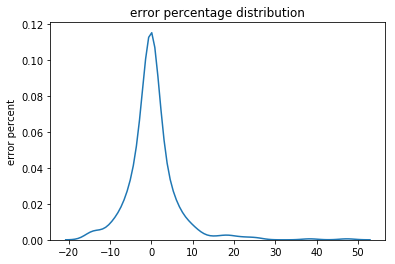

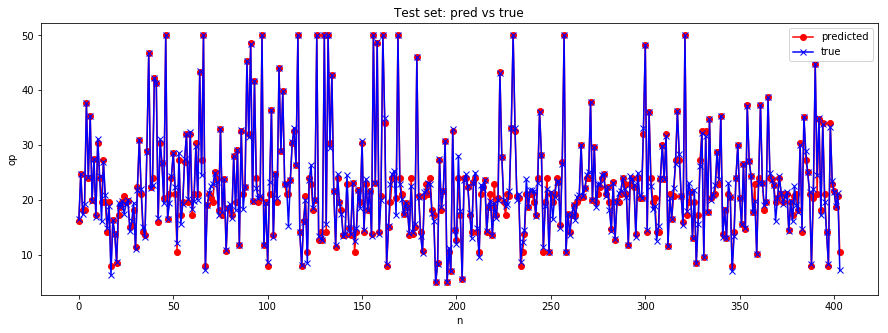

In [17]:
#Predicting and plotting the training set result
predict_and_plot(x_train_s, y_train, regressor, True)

MSE is:  16.916117487597468 
MAE is:  2.6881650205331002
mean error percent:  12.900938342719941
SD of error percent:  18.508579352321252
max error percent:  62.745098039215705
min error percent:  -52.400000000000006
+/- 5% accuracy:  36.27450980392157 %
+/- 10% accuracy:  57.84313725490197 %
+/- 15% accuracy:  66.66666666666666 %
+/- 20% accuracy:  78.43137254901961 %


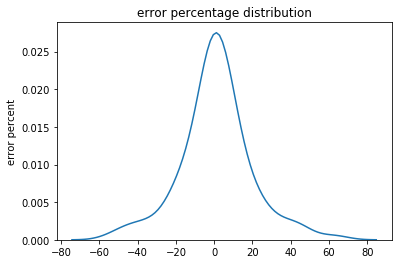

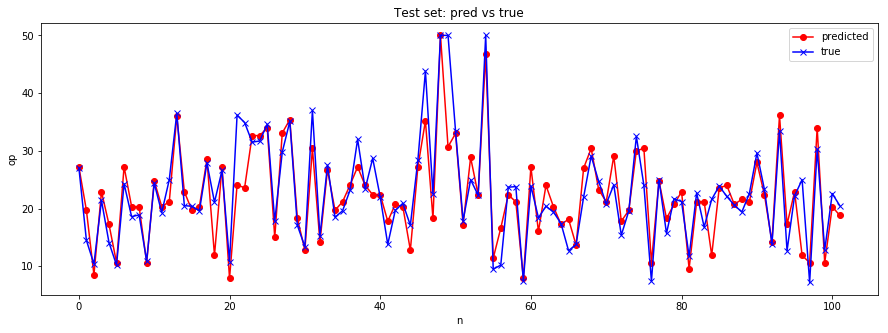

In [18]:
#Predicting and plotting the test set result
predict_and_plot(x_test_s, y_test, regressor, True)

In [19]:
regressor.get_depth()

9

In [20]:
regressor.get_n_leaves()

140

### Random forest regression model

In [21]:
#Fitting Random forest regression to training set
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=400, max_depth=16, max_leaf_nodes=250, random_state=10)
regressor.fit(x_train_s, y_train_s)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
                      max_features='auto', max_leaf_nodes=250,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

MSE is:  1.7473870972985215 
MAE is:  0.8363655021683325
mean error percent:  4.2813926425748505
SD of error percent:  6.967834369139689
max error percent:  41.185000000000024
min error percent:  -21.231199999999916
+/- 5% accuracy:  74.75247524752476 %
+/- 10% accuracy:  90.84158415841584 %
+/- 15% accuracy:  95.79207920792079 %
+/- 20% accuracy:  97.77227722772277 %


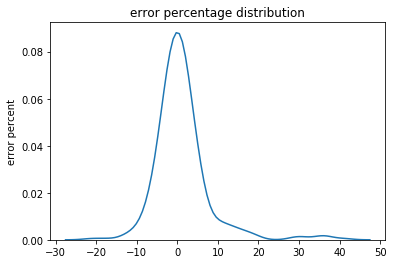

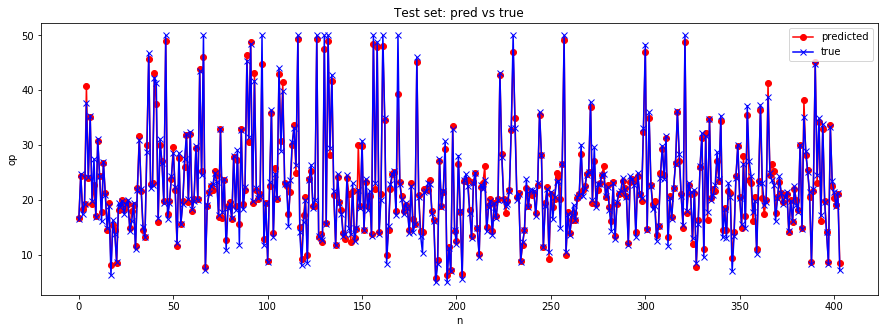

In [22]:
#Predicting and plotting the training set result
predict_and_plot(x_train_s, y_train, regressor, True)

MSE is:  10.346524213278867 
MAE is:  2.307954636394078
mean error percent:  10.926704395096976
SD of error percent:  14.454921292324912
max error percent:  56.92226890756314
min error percent:  -30.553176795580107
+/- 5% accuracy:  32.35294117647059 %
+/- 10% accuracy:  59.80392156862745 %
+/- 15% accuracy:  74.50980392156863 %
+/- 20% accuracy:  84.31372549019608 %


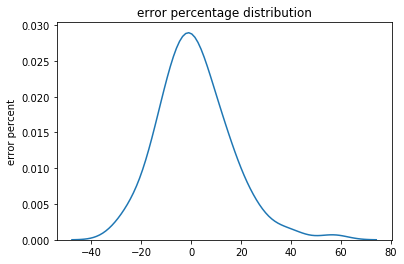

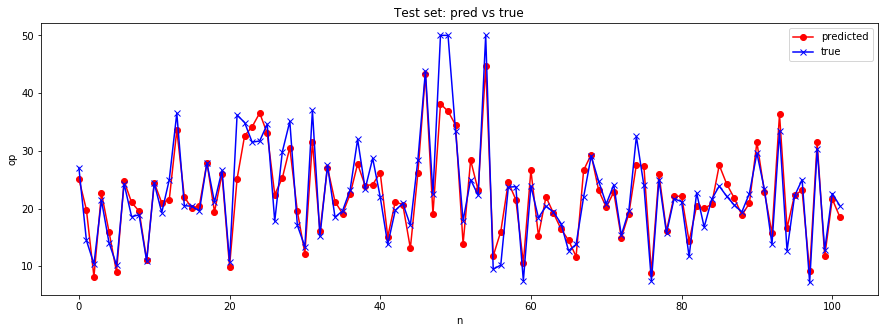

In [23]:
#Predicting and plotting the test set result
predict_and_plot(x_test_s, y_test, regressor, True)

In [24]:
xx = 100
print (regressor.estimators_[xx].get_depth())
print (regressor.estimators_[xx].get_n_leaves())

15
235


### Deeplearning regressor with keras

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [32]:
#Build the neural network with adam optimizer
regressor = Sequential()

#Add input layer and first layer
regressor.add(Dense(units=78, input_dim=13, activation='relu', kernel_initializer='he_normal'))
regressor.add(Dropout(rate=0.3))

#Add second layer
regressor.add(Dense(units=39, activation='relu', kernel_initializer='he_normal'))
regressor.add(Dropout(rate=0.2))

#Add third layer
regressor.add(Dense(units=13, activation='relu', kernel_initializer='he_normal'))
regressor.add(Dropout(rate=0.1))

#Add output layer
regressor.add(Dense(units=1, activation='relu', kernel_initializer='he_normal'))

#Compile the model
regressor.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

#Check the summary
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 78)                1092      
_________________________________________________________________
dropout_4 (Dropout)          (None, 78)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 39)                3081      
_________________________________________________________________
dropout_5 (Dropout)          (None, 39)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 13)                520       
_________________________________________________________________
dropout_6 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 14        
Total para

In [0]:
#Train the NN
history = regressor.fit(x_train_s, y_train, batch_size=4, epochs=1000, verbose=0)

MSE is:  2.485830967603066 
MAE is:  1.0019125461578369
mean error percent:  5.308571317232712
SD of error percent:  10.6817194869274
max error percent:  79.75621564047678
min error percent:  -37.25892098627408
+/- 5% accuracy:  69.55445544554455 %
+/- 10% accuracy:  91.0891089108911 %
+/- 15% accuracy:  94.3069306930693 %
+/- 20% accuracy:  96.53465346534654 %


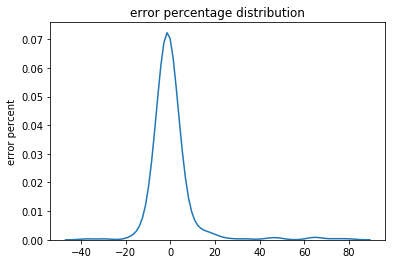

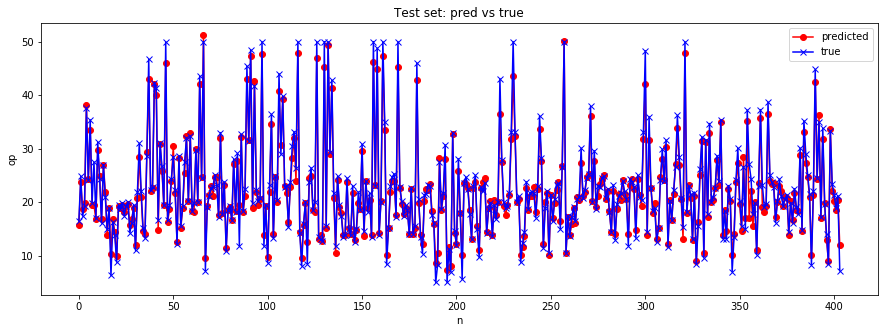

In [34]:
#Predicting and plotting the training set result
predict_and_plot(x_train_s, y_train, regressor, False)

MSE is:  9.021065537485669 
MAE is:  1.9153568660511695
mean error percent:  9.066161822765023
SD of error percent:  12.828672515250561
max error percent:  41.040868229336205
min error percent:  -36.90614700317383
+/- 5% accuracy:  46.07843137254902 %
+/- 10% accuracy:  65.68627450980392 %
+/- 15% accuracy:  79.41176470588235 %
+/- 20% accuracy:  89.2156862745098 %


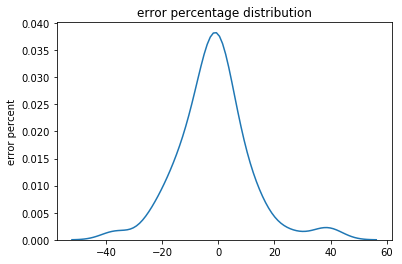

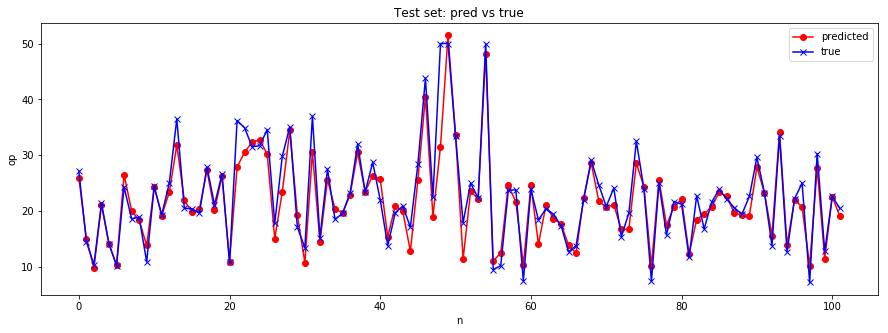

In [35]:
#Predicting and plotting the test set result
predict_and_plot(x_test_s, y_test, regressor, False)

#### Plotting Model accuracy during training

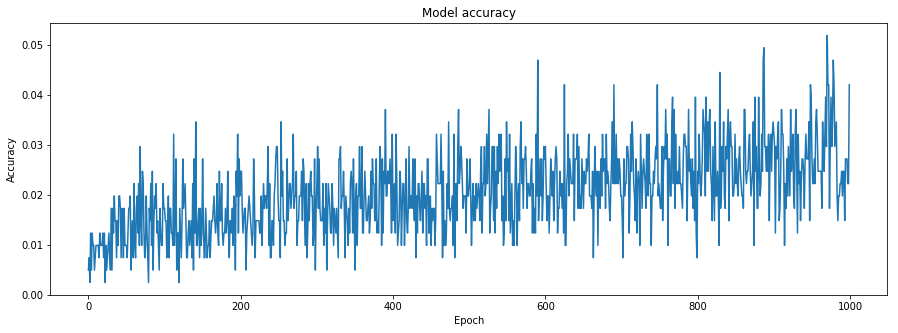

In [36]:
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### Plotting Model loss per epoch during training 

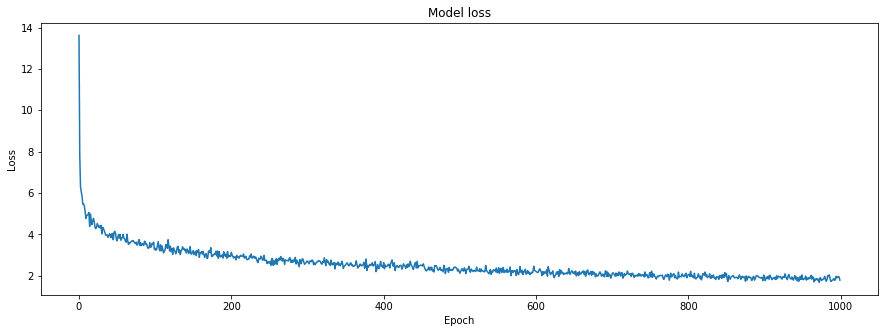

In [37]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Deeplearning regressor using batch normalization with tensorflow